In [1]:
### Essentials
import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta

#Plotting
import matplotlib.pyplot as plt
%matplotlib widget
import matplotlib.colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection

#Oceanography tools
import gsw # https://teos-10.github.io/GSW-Python/gsw_flat.html
from iapws import iapws95
from physoce import tseries as ts
from physoce import oceans as oc

#Scipy
from scipy.signal import welch 
from scipy.stats import chi2 
from scipy.special import gamma
from scipy import stats
from scipy import signal
from scipy.signal import periodogram
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.stats.distributions import  t

#Custom function packages
import vector_tools as vt
import Plot_tools as pt

### Load Data

In [206]:
# ADCP data
adcp1 = xr.open_dataset('ADCP/adcp1_qc.nc')
adcp2 = xr.open_dataset('ADCP/adcp2_qc.nc')


# Temperature data
temp = xr.open_dataset('Temperature/temp_final.nc')
temp1 = temp.where(temp.time.isin(adcp1.time)).dropna(dim='time', how='all')

ADCP pressure sensor is .396m above ground
ADCP fibergrate platform adds extra .0254m (1 inch)
ADCP blanking distance is .81m from transducer head
ADCP records first depth cell at 1.2314m above the bottom (~ 1.25m)

Total depth (H) is at ~10.7m (35 feet)

Depth of first cell is about 9.45m

In [207]:
#Correct the adcp bins to match the true height off the seafloor
adcp1['BinDist'] = adcp1.BinDist + .44

#Linearly interpolate Rho so that there is a density measure every .25 meters to match the adcp bins
RhoInterp = temp1.Rho.interp(bindist = adcp1.BinDist.values, method = 'linear')

### Richardson number Ri
- Ri = N^2 / (du/dz)^2
- N^2 = -(g/rho) * (drho/dz)

In [257]:
rSamp = '5Min'

RiDS = xr.Dataset(
        data_vars=dict(
            Vertical = (["binDist", "time"], adcp1.Vertical.values),
            Rho = (["binDist", "time"], RhoInterp.values),
            RhoBar = (["time"], RhoInterp.mean(dim='bindist').values),
        ),
        coords=dict(
            binDist=(["binDist"], adcp1.BinDist.data),
            time=(["time"], adcp1.time.data),
        ),
    )

if rSamp != '1Min':
    RiDS = RiDS.resample(time = rSamp).mean()

RiDS['dUdZ'] = RiDS.Vertical.diff(dim = 'binDist')/.25
RiDS['dRho'] = RiDS.Rho.diff(dim = 'binDist', label = 'lower')/.25

g = 9.81
RiDS['N2'] = RiDS.dRho * (-g/RiDS.RhoBar)
BV = RiDS.N2**.5
RiDS['BV_freq'] = BV.mean(dim='binDist')
RiDS['Ri'] = (RiDS.N2) / (RiDS.dUdZ**2) #Richardson number

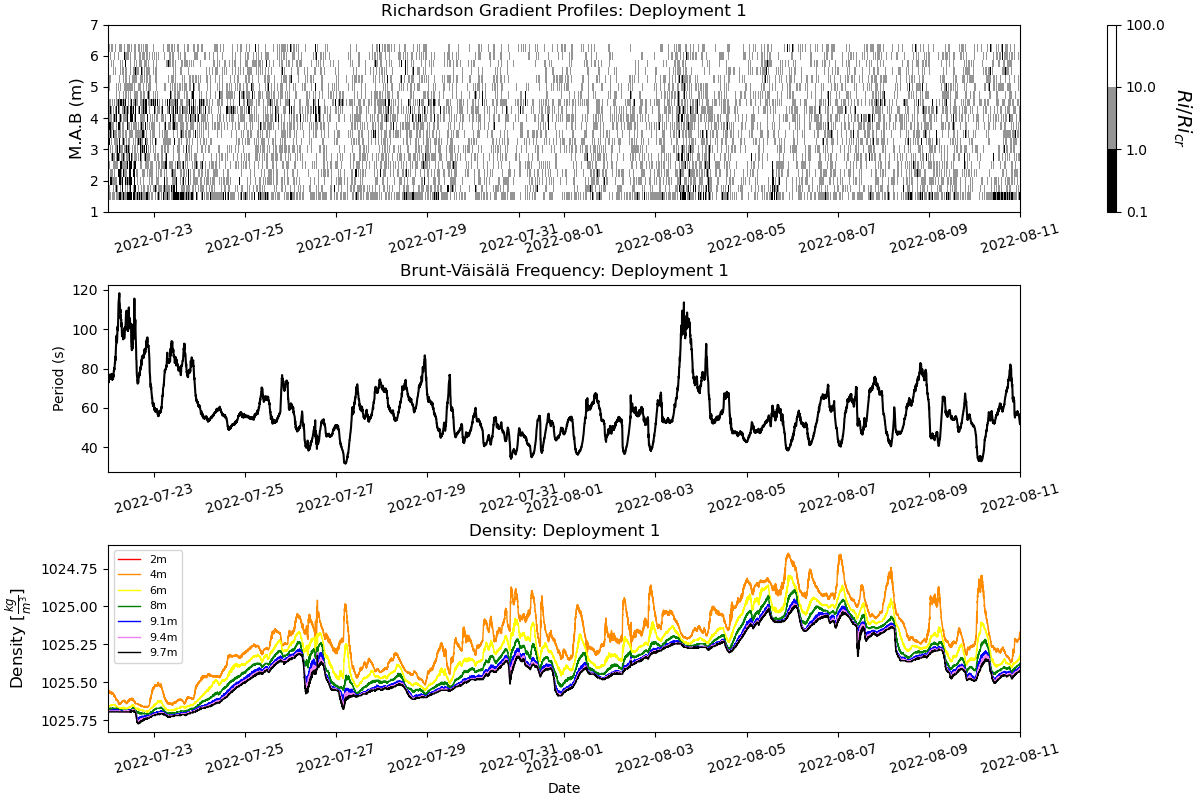

In [270]:
fig, ax = plt.subplots(3, 1, constrained_layout=True, figsize=(12,8))

bounds = np.array([.1, 1, 10, 100])
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
ax[0].set_title('Richardson Gradient Profiles: Deployment 1')
RiPlot = ax[0].pcolormesh(RiDS.time, RiDS.binDist, RiDS.Ri.T/.25, norm = norm, cmap = 'Greys_r', shading = 'nearest')
ax[0].set_ylabel('M.A.B (m)', fontsize = 12)
ax[0].tick_params(axis = 'x', labelrotation = 15)
ax[0].set_ylim(1,7)
fig.colorbar(RiPlot, location='right').set_label(label=r"$Ri/Ri_{cr}$",size=14,rotation = -90, va = 'bottom')

ax[1].set_title('Brunt-Väisälä Frequency: Deployment 1')
ax[1].plot(RiDS.time, 1/RiDS.BV_freq, '-k')
ax[1].set_ylabel('Period (s)')
ax[1].tick_params(axis = 'x', labelrotation = 15)
ax[1].margins(x=0)

ax[2].set_title('Density: Deployment 1')
ax[2].set_prop_cycle(c = ['red','darkorange','yellow','green','blue','violet','black'])
ax[2].plot(temp1.time, temp1.Rho.T, lw = 1)
ax[2].set_ylabel(r"Density [$\frac{kg}{m^{3}}$]", fontsize=12)
ax[2].set_xlabel('Date')
ax[2].invert_yaxis()
ax[2].tick_params(axis = 'x', labelrotation = 15)
ax[2].margins(x=.00)
ax[2].legend(['2m', '4m','6m','8m','9.1m', '9.4m', '9.7m'], fontsize=8)
